In [120]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
import string
%matplotlib inline

# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

#SKLearn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D, GRU
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jacob\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# NLP Disaster Tweets

Data: The data is downloaded from Kaggle.
Columns in the data:

    id - a unique identifier for each tweet
    text - the text of the tweet
    location - the location the tweet was sent from (may be blank)
    keyword - a particular keyword from the tweet (may be blank)
    target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

Using this data, we are going to trasnform the text, and embed it into 2 different RNN implementations, LSTM and GRU. We are then going to compare these models, and choose which one we are going to use to make predictions from our final submission.
   

## Exploritory Data Analysis

In [157]:
# Reading in the data
train = pd.read_csv('../NLPDisasterTweets/train.csv')
test = pd.read_csv('../NLPDisasterTweets/test.csv')

In [158]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [159]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [160]:
print(f'Size of Training Data: {train.shape[0]}')
print(f'Size of Testing Data: {test.shape[0]}')

Size of Training Data: 7613
Size of Testing Data: 3263


In [161]:
total = (test.shape[0] + train.shape[0])
test_per = test.shape[0] / total
train_per = train.shape[0] / total
print(f'Percentage split of training and Testing: {train_per} Training, {test_per} Testing.')

Percentage split of training and Testing: 0.6999816108863552 Training, 0.3000183891136447 Testing.


We have a 70/30 split for training/testing data. 


Next, lets look at a breakdown of the split of target values in the training set.

0 is for not a real disaster, 1 is for real disaster.

C:\anaconda3\envs\tensorflow\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='target'>

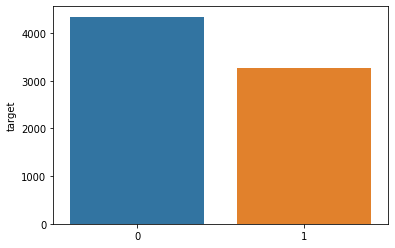

In [162]:
OneorZero = train.target.value_counts()
sns.barplot(OneorZero.index, OneorZero)

In [163]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Looking at the breakdown of Null values in the training dataset, we are not going to use location as a feature in the NN, it has too many null values to be of any real use.

So we are going to remove all the features except text and target in the training data, as these are really the only features we are intersted in. We don't need ID as this does not correspond to the id in the testing data, it is just the id for the training data.

For the testing data, we only want to keep the id and text features.

In [164]:
train = train[['text', 'target']].copy()
train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [165]:
test = test[['id', 'text']].copy()
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


I want to keep as much of the text the same as I can so, we are going to remove punctuation, URLs, emojis, and any non-ascii characters.

In [166]:
## Removing Punctuation
def remove_punct(text):
    temp = str.maketrans('', '', string.punctuation)
    return text.translate(temp)

## Removing URLs
def remove_url(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text

## Removing Emojis
def remove_emoji(text):
    # Copied from Kaggle, this is the unicode for the emojis we want to remove.
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis, '', text)
    return text

## Remove non-ascii characters
def remove_non_ascii(text):
    text = re.sub(r'[^\x00-\x7f]','', text)
    text = text.lower()
    return text

In [167]:
# Run the functions on the training data
train['cleaned_text'] = train['text'].apply(lambda x : remove_punct(x))
train['cleaned_text'] = train['cleaned_text'].apply(lambda x : remove_url(x))
train['cleaned_text'] = train['cleaned_text'].apply(lambda x : remove_emoji(x))
train['cleaned_text'] = train['cleaned_text'].apply(lambda x : remove_non_ascii(x))

train.head()

,text,target,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [168]:
#Run the functions on the testing data
test['cleaned_text'] = test['text'].apply(lambda x : remove_punct(x))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x : remove_url(x))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x : remove_emoji(x))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x : remove_non_ascii(x))

test.head()

,id,text,cleaned_text
0,0,Just happened a terrible car crash,just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s...",heard about earthquake is different cities sta...
2,3,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills 28 in china and taiwan


Next, we are going to be doing the very important work of making the text compatable with our models. First we are going to create a Corpus, which is just a fancy way of saying a large body of text.

In [89]:
# Creating Words Corpus
stop = set(stopwords.words('english'))
def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['cleaned_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
        corpus.append(words)
    return corpus

corpus = create_corpus(train)

100%|███████████████████████████████████████████████████████████████████████████| 7613/7613 [00:00<00:00, 12773.55it/s]


After createing the Corpus, we are going to create a embedding dictionary. This will make inputing the data into the NN much easier.

"Instead, in an embedding, words are represented by dense vectors where a vector represents the projection of the word into a continuous vector space.
The position of a word within the vector space is learned from text and is based on the words that surround the word when it is used.
The position of a word in the learned vector space is referred to as its embedding." - machinelearningmastery.com

We are going to use Stanford's GloVe 100d word embeddings to create the dictionary.

In [91]:
# Creating Embedding Dictionary

embedding_dict={}
with open('../NLPDisasterTweets/glove.6B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [92]:
# Tokenize : break the sentence into single word/token
# texts_to_sequences : convert tokenized word into an encoded sequnce
# pad_sequence : change the length of sequence by either adding or truncating

MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [93]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16983


In [94]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|████████████████████████████████████████████████████████████████████████| 16983/16983 [00:00<00:00, 629001.16it/s]


Now we are going to split up the new corpus into training and testing sets for our models.

In [177]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, train['target'].values, test_size = 0.25, random_state = 0 )

print('Shape of x_train',X_train.shape)
print("Shape of x_test ",X_test.shape)

print('Shape of y_train',y_train.shape)
print("Shape of y_test ",y_test.shape)

Shape of x_train (5709, 20)
Shape of x_test  (1904, 20)
Shape of y_train (5709,)
Shape of y_test  (1904,)


### LSTM 

In [146]:
model_lstm = Sequential(name='LSTM')
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model_lstm.add(embedding)
model_lstm.add(SpatialDropout1D(0.4))
model_lstm.add((LSTM(64, return_sequences = True, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_lstm.add(Dropout(0.5))
model_lstm.add((LSTM(32, return_sequences = False, recurrent_dropout=0.0, kernel_regularizer = L1L2(l1=0.0, l2=0.01))))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer = Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 20, 100)           1698400   
                                                                 
 spatial_dropout1d_14 (Spati  (None, 20, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_44 (LSTM)              (None, 20, 64)            42240     
                                                                 
 dropout_47 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_45 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_48 (Dropout)        (None, 32)                0         
                                                              

In [148]:
history=model_lstm.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Epoch 1/30
179/179 - 4s - loss: 1.2028 - accuracy: 0.7362 - val_loss: 0.5946 - val_accuracy: 0.7941 - 4s/epoch - 20ms/step
Epoch 2/30
179/179 - 1s - loss: 0.5619 - accuracy: 0.7793 - val_loss: 0.5101 - val_accuracy: 0.7952 - 937ms/epoch - 5ms/step
Epoch 3/30
179/179 - 1s - loss: 0.5362 - accuracy: 0.7772 - val_loss: 0.5021 - val_accuracy: 0.7915 - 929ms/epoch - 5ms/step
Epoch 4/30
179/179 - 1s - loss: 0.5130 - accuracy: 0.7814 - val_loss: 0.5079 - val_accuracy: 0.7847 - 942ms/epoch - 5ms/step
Epoch 5/30
179/179 - 1s - loss: 0.5139 - accuracy: 0.7754 - val_loss: 0.4780 - val_accuracy: 0.7946 - 917ms/epoch - 5ms/step
Epoch 6/30
179/179 - 1s - loss: 0.5060 - accuracy: 0.7751 - val_loss: 0.4776 - val_accuracy: 0.7957 - 960ms/epoch - 5ms/step
Epoch 7/30
179/179 - 1s - loss: 0.5084 - accuracy: 0.7763 - val_loss: 0.4810 - val_accuracy: 0.7978 - 928ms/epoch - 5ms/step
Epoch 8/30
179/179 - 1s - loss: 0.5037 - accuracy: 0.7763 - val_loss: 0.4784 - val_accuracy: 0.7936 - 905ms/epoch - 5ms/step
Ep

In [149]:
info_lstm = pd.DataFrame(history.history)
info_lstm

,loss,accuracy,val_loss,val_accuracy
0,1.202807,0.736206,0.594620,0.794118
1,0.561916,0.779296,0.510080,0.795168
2,0.536216,0.777194,0.502133,0.791492
3,0.513033,0.781398,0.507918,0.784664
4,0.513934,0.775442,0.478024,0.794643
5,0.505980,0.775092,0.477640,0.795693
6,0.508382,0.776318,0.480976,0.797794
7,0.503687,0.776318,0.478381,0.793592
8,0.505418,0.782274,0.477914,0.791492
9,0.498034,0.779471,0.479895,0.798319


In [150]:
print(f'Highest Accuracy: {max(info_lstm.accuracy)}')
print(f'Highest Validation Accuracy: {max(info_lstm.val_accuracy)}')

Highest Accuracy: 0.7926081418991089
Highest Validation Accuracy: 0.8088235259056091


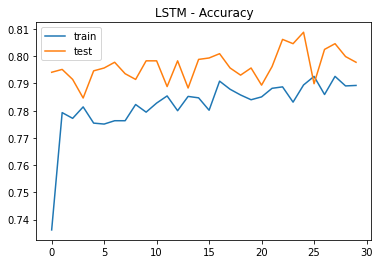

In [151]:
# Accuracy vs Epoch
plt.title('LSTM - Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

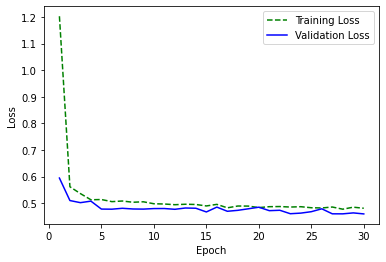

In [155]:
# Loss vs Epoch
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'g--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Looking at the information above, we can see that the LSTM model does a good job with the data. The highest accuracy and validation accuracy we get are 0.7926 and 0.8088, respectively. Looking at the accuracy graph, we can see that the model never really levels off, it jumps around a bit. The Loss graph does almost level out, once we get to the 10th epoch, it looks like the loss mostly levels out.

### GRU

Next, lets compare a GRU model to out LSTM model.

In [142]:
model_gru = Sequential(name='GRU')
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model_gru.add(embedding)
model_gru.add(SpatialDropout1D(0.4))
model_gru.add(GRU(1))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer = Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 20, 100)           1698400   
                                                                 
 spatial_dropout1d_13 (Spati  (None, 20, 100)          0         
 alDropout1D)                                                    
                                                                 
 gru_8 (GRU)                 (None, 1)                 309       
                                                                 
 dropout_46 (Dropout)        (None, 1)                 0         
                                                                 
 dense_53 (Dense)            (None, 16)                32        
                                                                 
 dense_54 (Dense)            (None, 1)                 17        
                                                               

In [143]:
history_gru=model_gru.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Epoch 1/30
179/179 - 2s - loss: 0.6888 - accuracy: 0.5628 - val_loss: 0.6831 - val_accuracy: 0.5814 - 2s/epoch - 10ms/step
Epoch 2/30
179/179 - 1s - loss: 0.6849 - accuracy: 0.5666 - val_loss: 0.6805 - val_accuracy: 0.5814 - 635ms/epoch - 4ms/step
Epoch 3/30
179/179 - 1s - loss: 0.6843 - accuracy: 0.5666 - val_loss: 0.6806 - val_accuracy: 0.5814 - 540ms/epoch - 3ms/step
Epoch 4/30
179/179 - 1s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6808 - val_accuracy: 0.5814 - 572ms/epoch - 3ms/step
Epoch 5/30
179/179 - 1s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6809 - val_accuracy: 0.5814 - 539ms/epoch - 3ms/step
Epoch 6/30
179/179 - 1s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6806 - val_accuracy: 0.5814 - 539ms/epoch - 3ms/step
Epoch 7/30
179/179 - 1s - loss: 0.6843 - accuracy: 0.5666 - val_loss: 0.6802 - val_accuracy: 0.5814 - 530ms/epoch - 3ms/step
Epoch 8/30
179/179 - 1s - loss: 0.6844 - accuracy: 0.5666 - val_loss: 0.6800 - val_accuracy: 0.5814 - 526ms/epoch - 3ms/step
Ep

In [144]:
info_gru = pd.DataFrame(history_gru.history)
info_gru

,loss,accuracy,val_loss,val_accuracy
0,0.688836,0.562796,0.683145,0.581408
1,0.684917,0.566649,0.680469,0.581408
2,0.684334,0.566649,0.680602,0.581408
3,0.684400,0.566649,0.680766,0.581408
4,0.684365,0.566649,0.680911,0.581408
5,0.684366,0.566649,0.680629,0.581408
6,0.684294,0.566649,0.680209,0.581408
7,0.684419,0.566649,0.680035,0.581408
8,0.684461,0.566474,0.680011,0.581408
9,0.684352,0.566649,0.680245,0.581408


In [145]:
print(f'Highest Accuracy: {max(info_gru.accuracy)}')
print(f'Highest Validation Accuracy: {max(info_gru.val_accuracy)}')

Highest Accuracy: 0.6806796193122864
Highest Validation Accuracy: 0.7920168042182922


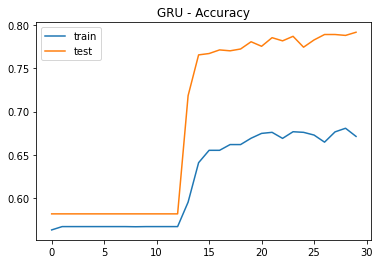

In [153]:
# Accuracy vs Epoch
plt.title('GRU - Accuracy')
plt.plot(history_gru.history['accuracy'], label='train')
plt.plot(history_gru.history['val_accuracy'], label='test')
plt.legend()
plt.show();

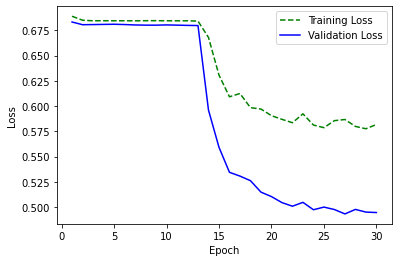

In [156]:
# Loss vs Epoch
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.

epoch_count = range(1, len(history_gru.history['loss']) + 1)
plt.plot(epoch_count, history_gru.history['loss'], 'g--')
plt.plot(epoch_count, history_gru.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Looking at the information above, it looks like the LSTM model barely outperformed the GRU model on Validation accuracy, while it was much better at training accuracy. GRU ended up with 0.6806 and 0.7920 being the accuracy and training accuracy, repectively. Looking at the graphs though, we can see that the model doesn't improve in accuracy or loss until about the 12th epoch, then it jumps up and performs much better in validation accuracy and loss, than training accuracy and loss.

## Predictions on Test Set for Submission

Because the LSTM had the higher accuracy and was alot more stable, thats the model that I am going to use for the predictions.

In [169]:
# Creating Test Corpus
test_corpus = create_corpus(test)

100%|███████████████████████████████████████████████████████████████████████████| 3263/3263 [00:00<00:00, 14899.70it/s]


In [170]:
# Encoding Test Text to Sequences
test_sequences = tokenizer.texts_to_sequences(test_corpus)
test_corpus_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [175]:
# Predictions
predictions = model_lstm.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)

In [176]:
# Creating submission file 
submission = pd.DataFrame({'id' : test['id'], 'target' : predictions})
submission.to_csv('final_submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


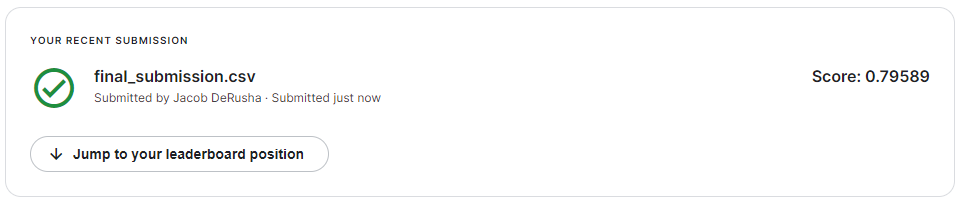

## Conclusion

Having submitted the predictions to Kaggle and getting a score of 0.7958, I am happy with my model implemintation.

Comparing the two models, GRU and LSTM, our LSTM model performed better. It achieved both a higher training accuracy and a higher validation accuracy. 

I could have probably made the GRU model more complex, maybe adding more than one GRU layer. But with the accuracy coming out to be just under .80, I was happy with using it as a actual model.


### Refrences:

    https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
    https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation/notebook 
    https://www.kaggle.com/code/asmaamosa/nlp-getting-started
    https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt
    https://www.kaggle.com/code/anshulmehtakaggl/intro-to-nlp-with-tensorflow

